In [36]:
import numpy as np
from numpy import eye, array, asarray
from numpy.linalg import inv
from numpy.random import randn
import math
from math import sqrt
import matplotlib.pyplot as plt

In [43]:
class KalmanFilter:
    def __init__(self):
        self.M = None
        self.H = None
        self.mu = None
        self.Sigma = None
        self.Sigma_y = None
        self.Q = None
        
    def predict_response(self):
        return self.H @ self.mu
    
    # KF assimilation
    def update(self, y_t):
        # Predict y to measure innovation
        y_hat = self.predict_response()
        # Calculate Kalman gain
        K = self.Sigma @ self.H.T @ inv(self.H @ self.Sigma @ self.H.T + self.Sigma_y)
        # Update belief
        I = np.identity(self.mu.size)
        self.mu = self.mu + K @ (y_t - y_hat)
        self.Sigma = (I-K@self.H)@self.Sigma
    
    # time dynamics
    def predict(self):
        self.mu = self.M @ self.mu
        self.Sigma = self.M @ self.Sigma @ self.M.T + self.Q

*Ensemble Kalman Filteret* blir relevant når tids-dynamikkar er svært ikkje-lineære og Jacobianen ikkje kan reknast analytisk, numerisk, eller med bruk av automatisk differensiering.

\begin{align}
\mathbf{x}_{t|t-1} &= m(\mathbf{x}_{t-1|t-1})\\
\hat{\mathbf{y}}_{t} &= h(\mathbf{x}_{t|t-1})
\end{align}

In [44]:
class EnsembleKalmanFilter(KalmanFilter):
    def __init__(self, N, mu, Sigma):
        super().__init__()
        self.m = None
        self.N = N
        self.mu = mu
        self.Sigma = Sigma
        self.ensemble = np.random.multivariate_normal(mu, Sigma, N)
        
    def update(self, y_t):
        super().update(y_t)
        self.ensemble = np.random.multivariate_normal(self.mu, self.Sigma, self.N)
    
    def predict(self):
        self.ensemble = array([m(x) for x in self.ensemble])
        self.mu = self.ensemble.mean(axis=0)
        self.Sigma = np.cov(self.ensemble, rowvar=False)

In [45]:
# Initialize the Kalman Filter
enkf = EnsembleKalmanFilter(
    N=1000,
    mu=array([3,4]), 
    Sigma=array([
    [50,0],
    [0,50]
])
)


# predict dynamics
dt = 1
#enkf.M = array([[1,dt],
#      [0,1]])
def m(x):
    pos = x[0] + x[1]
    v = x[1]
    return [pos, v]
enkf.m = m
enkf.Q = eye(2)*0
# update dynamics
enkf.H = array([
    [1,0]
])
# noise of observations
enkf.Sigma_y = None #added later

In [46]:
# Create observations
Sigma_y = array([
    [50,0],
    [0,1]
])
enkf.Sigma_y = Sigma_y[0,0]
T = 30
x_truth = [array([[50],[2]])]
for t in range(1,T):
    x_truth.append(enkf.m(x_truth[t-1]))
x_obs = [xt + np.random.multivariate_normal([0,0], Sigma_y, 1).T for xt in x_truth]

In [47]:
# Assimilate over time
time = np.linspace(1,T,T)
pos_truth = [o[0] for o in x_truth]
pos_obs = [obs[0] for obs in x_obs]
mu_prior = []
mu_posterior = []
for t in range(T):
    mu_prior.append(enkf.mu[0])
    # assimilation step
    enkf.update(pos_obs[t])
    mu_posterior.append(enkf.mu[0])
    # time dynamics for next iteration
    enkf.predict()

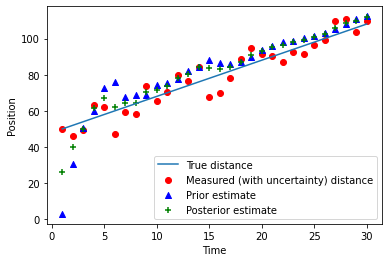

In [48]:
# Inspect
plot1 = plt.figure(1)
plt.plot(time, pos_truth)
plt.scatter(time, pos_obs, color="red")
plt.ylabel('Position')
plt.xlabel('Time')
plt.scatter(time, mu_prior, color="blue", marker="^")
plt.scatter(time, mu_posterior, color="green", marker="+")
plt.legend(['True distance', 
            'Measured (with uncertainty) distance', 
            'Prior estimate',
            'Posterior estimate'])
plt.show()